# 주가수익률의 시계열 분석

In [1]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## 주가데이터 불러오기
yahoo finance open api
- KRX에 등록된 상장 주식은 Ticker(종목코드)가 있음
- Ticker + .ks -> 한국거래소 상장 주식

수정종가(Adj Close) 아닌 종가(Close) 사용
- 기본적으로 pricing에서는 adj close 사용
- 실제 real time에서 관측하는 종가는 adj close 아닌 close이기 때문

In [2]:
start = datetime(2019, 1, 1)
end = datetime(2020, 1, 1)

In [3]:
ss = pdr.DataReader('005930.ks', 'yahoo', start, end)

In [5]:
ss.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39400.0,38550.0,39400.0,38750.0,7847664.0,35976.949219
2019-01-03,38550.0,37450.0,38300.0,37600.0,12471493.0,34909.246094
2019-01-04,37600.0,36850.0,37450.0,37450.0,14108958.0,34769.980469
2019-01-07,38900.0,37800.0,38000.0,38750.0,12748997.0,35976.949219
2019-01-08,39200.0,37950.0,38000.0,38100.0,12756554.0,35373.460938


### Moving average window 결정

In [9]:
short_window = 20 ### 통상 한달 간의 거래일
long_window = 80 ### 통상 한달 거래일의 4배가 되는 수치 (임의로 설정)

In [10]:
# Signal을 정할 때 moving average 값이 필요함

signals = pd.DataFrame(index=ss.index)
signals['signal'] = 0.0

# MA20 for daily data > short moving average라는 칼럼으로 저장
signals['short_mavg'] = ss['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# MA80 for daily data > long moving average라는 칼럼으로 저장
signals['long_mavg'] = ss['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

## 투자 전략
- short moving average (20d) > long moving average (80d)
    - 단기 균형이 크다
    - BUY
- short moving average (20d) < long moving average (80d)
    - 단기 균형이 작다
    - SELL

In [11]:
# 매수, 매도 시점 판단을 위하여 short_mavg가 long_mavg보다 크면 모두 1로 표시

signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

### Position 계산
- short_mavg, long_mavg 바탕으로 계산한 signal의 미분값
- 0이 계속되다가 1이 처음 등장하게 되면 미분값이 커지게 되며, 이를 매수시점으로 판단
    - 이후 다시 signal 0이 지속되다가 다시 바뀌게 되면 매도시점으로 판단

In [12]:
signals['positions'] = signals['signal'].diff()

In [24]:
signals[173:178]

,signal,short_mavg,long_mavg,positions
Date,,,,
2019-09-16,0.0,44747.5,44868.125,0.0
2019-09-17,0.0,44897.5,44910.625,0.0
2019-09-18,1.0,45102.5,44958.750,1.0
2019-09-19,1.0,45337.5,45039.375,0.0
2019-09-20,1.0,45572.5,45121.250,0.0


<AxesSubplot:xlabel='Date'>

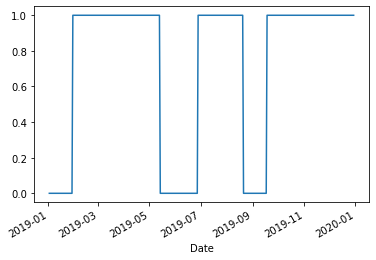

In [25]:
signals.signal.plot()

<AxesSubplot:xlabel='Date'>

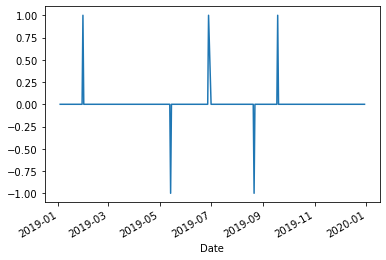

In [26]:
signals.positions.plot()

# 0 -> 1 : Buy
# 0 -> -1 : Sell

### 시각화
- 붉은 선 = 종가
- 붉은색 삼각형 마커 = BUY
- 검정색 역삼각형 마커 = SELL

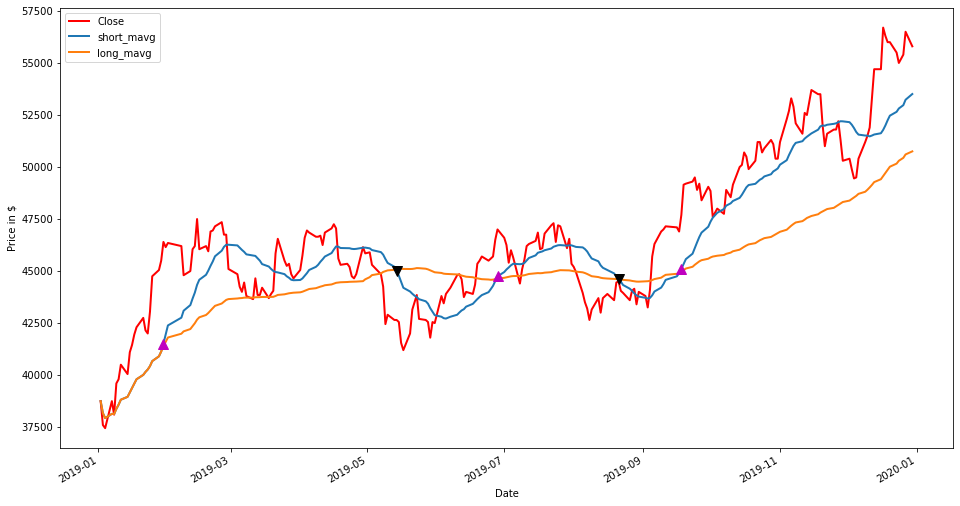

In [29]:
fig = plt.figure(figsize=(16, 9))

ax1 = fig.add_subplot(111, ylabel='Price in $')
ss['Close'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

ax1.plot(signals.loc[signals.positions==1.0].index,
        signals.short_mavg[signals.positions==1.0],
        '^', markersize=10, color='m')

ax1.plot(signals.loc[signals.positions==-1.0].index,
        signals.short_mavg[signals.positions==-1.0],
        'v', markersize=10, color='k')

plt.legend()
plt.show()

## 투자전략 성과 평가
cash flow - 1000만원, 100주 매입

In [49]:
initial_capital = float(10000000.0)

# signals 데이터의 날짜 인덱스를 받아오고 컬럼은 없는 상태로 position dataframe 생성
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions.head()

""
Date
2019-01-02
2019-01-03
2019-01-04
2019-01-07
2019-01-08


In [53]:
# signals 데이터프레임의 signal 컬럼에 100 곱한 타임시리즈를 position 데이터프레임의 ss 칼럼에 assign
positions['ss'] = 100*signals['signal']
print(positions['ss'].unique())
positions.head()

[  0. 100.]


,ss
Date,
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-07,0.0
2019-01-08,0.0


In [54]:
# 삼성전자 종가에 positions (0 or 100) 곱한 데이터를 portfolio 변수명으로 저장
portfolio = positions.multiply(ss['Close'], axis=0)
portfolio.head()

,ss
Date,
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-07,0.0
2019-01-08,0.0


In [33]:
# 미분값 별도 저장
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(ss['Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(ss['Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()*100

portfolio['Close'] = ss['Close']
portfolio['ret_Close'] = ss['Close'].pct_change()*100 ## percentage 변환 후 100 곱함 (종가를 수익률로 변환)
portfolio['ret_position'] = portfolio['ret_Close'].mul(signals['signal'])
portfolio['signal'] = signals['signal']
portfolio['positions'] = signals['positions']

### 시각화

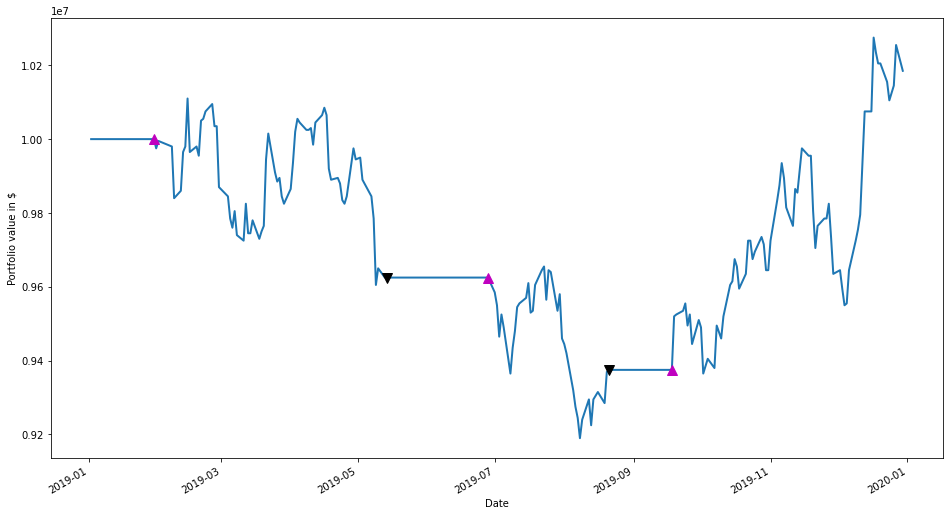

In [35]:
### visualization

fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions==1.0].index,
        portfolio.total[signals.positions==1.0],
        '^', markersize=10, color='m')

ax1.plot(portfolio.loc[signals.positions==-1.0].index,
        portfolio.total[signals.positions==-1.0],
        'v', markersize=10, color='k')

plt.show()

### 성과 평가를 위한 sharpe ratio

In [36]:
returns = portfolio['returns']
sharpe_ratio = np.sqrt(252)*(returns.mean() / returns.std())

sharpe_ratio

0.2500401895105333

### Stock Return
- stock return이 1년간 얼마만큼의 움직임을 보였는가?

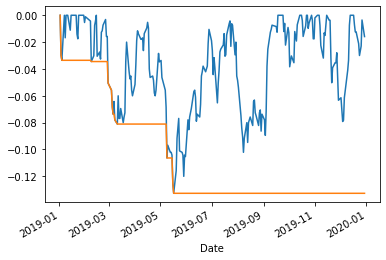

In [37]:
window = 252

rolling_max = ss['Close'].rolling(window, min_periods = 1).max()
daily_drawdown = ss['Close'] / rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(window, min_periods = 1).min()

daily_drawdown.plot()
max_daily_drawdown.plot()

plt.show()

### Compound Annual Growth Rate

In [44]:
days = (ss.index[-1] - ss.index[0]).days
cagr = (((((ss['Close'][-1]) / ss['Close'][0])) ** (365.0/days)) - 1)*100

cagr

44.435812372883035

### Benchmark
Moving average crossover 전략의 성과 비교를 위한 벤치마크
- 2019년 1년간 삼성전자 주식을 연초에 매수, 연말에 매도 > holding period return = benchmark

In [45]:
# Holding Period Return
# 2019년 초기 매수하여 1년간 홀딩하고 매수하면 약 36% 수익
ret_ss_hpr = 100 * np.log(ss.Close[-1] / ss.Close[0])
ret_ss_hpr

36.46431135879092

In [46]:
# moving average crossover
# 약 8% 수익
ret_strategy = portfolio['ret_position'].sum()
ret_strategy

8.170941754549668

### 벤치마크를 크게 하회하는 이유?
- Moving average corssover 이행 과정에서 2회 손실을 보게 되었음
- 9~10월 매수 이후로 주가가 상승하여 손실 만회하고 수익 

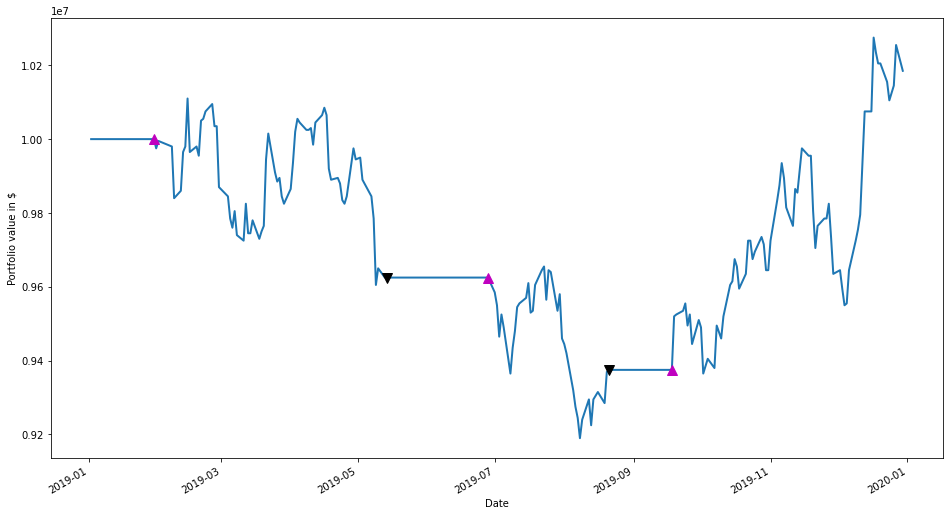

In [47]:
### visualization

fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions==1.0].index,
        portfolio.total[signals.positions==1.0],
        '^', markersize=10, color='m')

ax1.plot(portfolio.loc[signals.positions==-1.0].index,
        portfolio.total[signals.positions==-1.0],
        'v', markersize=10, color='k')

plt.show()

## 투자 전략 개선
### 벤치마크 전략을 능가하는 투자 전략 찾기
- long window, short window 값 바꿔보기
- 추가적인 제약으로 투자 전략성과 개선시키기

> 투자 전략이 벤치마크 대비 초과수익률을 누리는 것은 매우 어려운 일